In [1]:
from google.colab import files

print("Upload AI_vs_human_train_dataset:")
uploaded_train = files.upload()
print("Final_test_data:")
uploaded_test = files.upload()


Upload AI_vs_human_train_dataset:


Saving AI_vs_human_train_dataset.xlsx to AI_vs_human_train_dataset.xlsx
Final_test_data:


Saving Final_test_data.csv to Final_test_data.csv


I.
Required Libraries

In [2]:
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import re
nltk.download('stopwords')
# Machine Learning
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score,
StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score,
roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from scipy.stats import ttest_rel
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from wordcloud import WordCloud
from sklearn.ensemble import AdaBoostClassifier


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2. Code Structure

I. Data Loading and Exploration
Dataset loading and basic analysis

In [3]:
# load uploaded files
df_train = pd.read_excel('AI_vs_human_train_dataset.xlsx')
df_test = pd.read_csv('Final_test_data.csv')


In [5]:
df_train.shape

(3728, 2)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   essay   3728 non-null   object
 1   label   3728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.4+ KB


In [7]:
df_train.head()

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


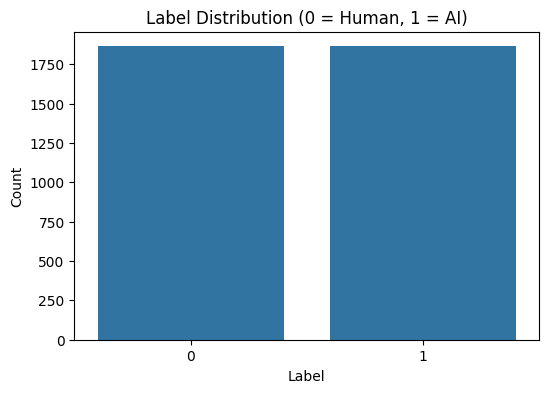

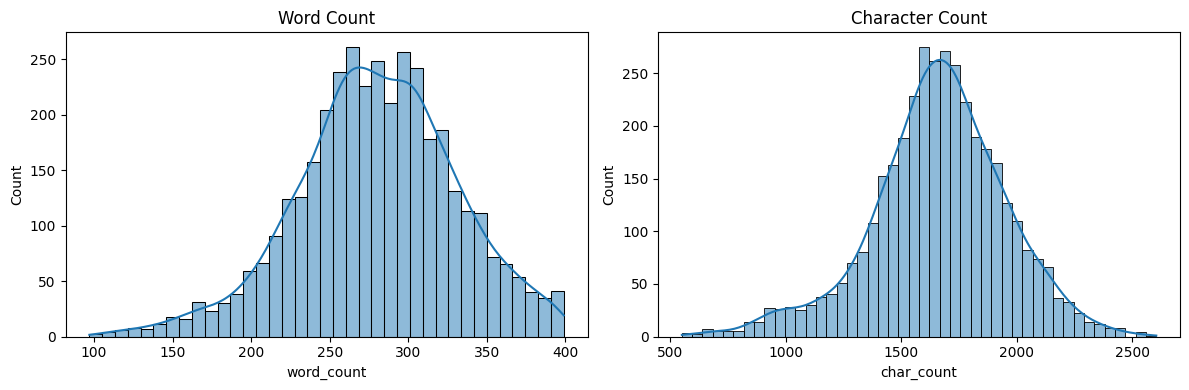

Correlation matrix:


,label,word_count,char_count
label,1.000000,-0.390459,-0.191035
word_count,-0.390459,1.000000,0.920660
char_count,-0.191035,0.920660,1.000000


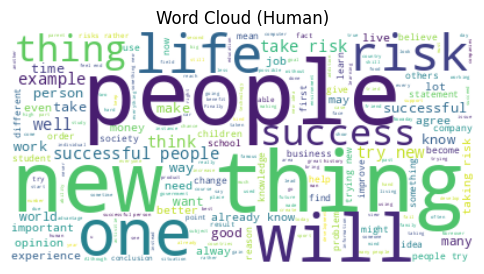

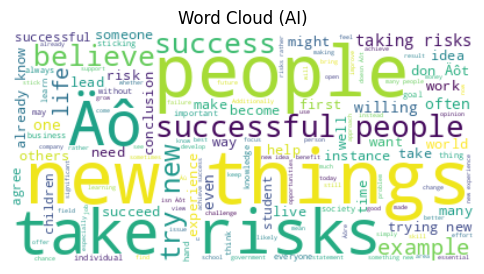

In [14]:

# 2. Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_train)
plt.title('Label Distribution (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 3. Word-count and character-count features
df_train['word_count'] = df_train['essay'].str.split().apply(len)
df_train['char_count'] = df_train['essay'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_train['word_count'], kde=True, ax=axes[0]).set_title('Word Count')
sns.histplot(df_train['char_count'], kde=True, ax=axes[1]).set_title('Character Count')
plt.tight_layout()
plt.show()

# 4. Correlation matrix
corr = df_train[['label','word_count','char_count']].corr()
print("Correlation matrix:")
display(corr)

# 5. Word clouds for each class
for lbl, name in [(0, 'Human'), (1, 'AI')]:
    text = " ".join(df_train[df_train['label']==lbl]['essay'])
    wc = WordCloud(max_words=200, background_color='white').generate(text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud ({name})")
    plt.show()


II.
Data Loading and Exploration
Dataset loading and basic analysis
Preprocessing Functions
a. Text cleaning utilities, preprocessing pipeline components


In [4]:
# Preprocessing pipeline
def preprocess_text(text: str) -> str:

    if pd.isna(text) or not isinstance(text, str):  # Handle NaN values
        return ""
    #Normalize text
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # replace non letters with a space
    text = re.sub(r'\s+', ' ', text).strip()  # remove whitespace
    #Tokenize and filter
    toks = text.split()
    toks = [t for t in toks if not re.search(r'\d', t)] # remove tokens with any digit
    toks = [t for t in toks if t.isalpha()]    # ensure token is only letters
    #remove stopwords and short tokens
    stop_words = set(stopwords.words('english'))
    toks = [t for t in toks if t not in stop_words and len(t) > 1]
    #Stemmatization
    stemmer = SnowballStemmer('english')
    toks = [stemmer.stem(t) for t in toks]
    #Return tokens as a single string
    return " ".join(toks)


In [5]:
# Run the preprocessing pipeline on each essay
df_train['essay_clean'] = df_train['essay'].apply(preprocess_text)
# Now df_train['essay_clean'] contains the cleaned + stemmed text
print(df_train[['essay', 'essay_clean']].head())

                                               essay  \
0  International sports events require the most w...   
1  Globalisation has become a significant aspect ...   
2  There is an ever-increasing number of bullying...   
3  It is commonly believed, that companies should...   
4  Despite knowing about the adverse effects of c...   

                                         essay_clean  
0  intern sport event requir well train athlet co...  
1  globalis becom signific aspect world modern ec...  
2  ever increas number bulli activ numer school a...  
3  common believ compani dress code polici employ...  
4  despit know advers effect climat chang human a...  


In [6]:
print("Original text:",  df_train['essay'].iloc[0])
print("Processed/ cleaned text:", df_train['essay_clean'].iloc[0])

Original text: International sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build infrastructure designed to train top athletes. Although this policy can indeed make fewer sports facilities for ordinary people, investing in the best athletes is vital to develop competitive sports performances in each country.
On the one hand, building specific infrastructure for the best athletes is crucial in order to get better results at international sports events such as The Olympics or the World Cup. The importance of getting better results is that it creates awareness of the importance of sports in society and motivates more people to do a sport. In this way, investing in these developments can help countries to develop an integral sport policy that can benefit everyone.
On the other hand, one can argue that a negative effect could be that less infrastructure is built for the rest of the people. However, people who

In [7]:
# Loading preprocessed data for modeling
X = df_train['essay_clean']
y = df_train['label']
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Label distribution:\n{y.value_counts()}")

X shape: (3728,)
y shape: (3728,)
Label distribution:
label
0    1864
1    1864
Name: count, dtype: int64


In [8]:
# Create Train / validation split
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Training samples: 2982, Validation samples: 746


In [9]:
# II. Model Development & Optimization

# Custom transformer for text length
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array([len(txt.split()) for txt in X]).reshape(-1,1)

# Combine TF-IDF and TextStats
text_features = FeatureUnion([
    ('tfidf', TfidfVectorizer()),    # hyperparams tuned in grid
    ('stats', TextStats())
])

# Pipelines
svm_pipe = Pipeline([
    ('features', text_features),
    ('clf', SVC(probability=True, random_state=42))
])

dt_pipe = Pipeline([
    ('features', text_features),
    ('clf', DecisionTreeClassifier(random_state=42))
])

adb_pipe = Pipeline([
    ('features', text_features),
    ('clf', AdaBoostClassifier(random_state=42))
])

# Parameter grids (only best‐found hyperparams for SVM & DT; full grid for AdaBoost)
svm_params = {
    'features__tfidf__max_features': [10000],
    'features__tfidf__ngram_range': [(1, 3)],
    'clf__C': [10],
    'clf__kernel': ['linear'],
    'clf__gamma': ['scale']
}

dt_params = {
    'features__tfidf__max_features': [10000],
    'features__tfidf__ngram_range': [(1, 1)],
    'clf__criterion': ['gini'],
    'clf__max_depth': [10],
    'clf__min_samples_leaf': [1],
    'clf__min_samples_split': [5]
}

adb_params = {
    'features__tfidf__max_features': [5000, 10000],
    'features__tfidf__ngram_range': [(1, 2), (1, 3)],
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.5, 1.0, 1.5]
}

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define GridSearchCV objects (scoring by accuracy to match your previous CV metric)
svm_gs = GridSearchCV(svm_pipe, svm_params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
dt_gs  = GridSearchCV(dt_pipe,  dt_params,  cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
adb_gs = GridSearchCV(adb_pipe, adb_params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# 2.1 SVM Tuning
print("Starting SVM GridSearchCV")
svm_gs.fit(X_train, y_train)
print("SVM best parameters:", svm_gs.best_params_)
print("SVM best Cross-Validation accuracy:", svm_gs.best_score_)

# 2.2 Decision Tree Tuning
print("Starting Decision Tree GridSearchCV")
dt_gs.fit(X_train, y_train)
print("Decision Tree best parameters:", dt_gs.best_params_)
print("Decision Tree best Cross-Validation accuracy:", dt_gs.best_score_)

# 2.3 AdaBoost Tuning
print("Starting AdaBoost GridSearchCV")
adb_gs.fit(X_train, y_train)
print("AdaBoost best parameters:", adb_gs.best_params_)
print("AdaBoost best Cross-Validation accuracy:", adb_gs.best_score_)


Starting SVM GridSearchCV
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM best parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'features__tfidf__max_features': 10000, 'features__tfidf__ngram_range': (1, 3)}
SVM best Cross-Validation accuracy: 0.9664659988982945
Starting Decision Tree GridSearchCV
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Decision Tree best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'features__tfidf__max_features': 10000, 'features__tfidf__ngram_range': (1, 1)}
Decision Tree best Cross-Validation accuracy: 0.8356823266219239
Starting AdaBoost GridSearchCV
Fitting 5 folds for each of 36 candidates, totalling 180 fits
AdaBoost best parameters: {'clf__learning_rate': 1.5, 'clf__n_estimators': 200, 'features__tfidf__max_features': 10000, 'features__tfidf__ngram_range': (1, 3)}
AdaBoost best Cross-Validation accuracy: 0.9641153193259362


In [10]:
# V. Build Final Pipelines with Best Params

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

print("Creating deployment pipelines…")

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000, ngram_range=(1,3),
        min_df=2, max_df=0.95, stop_words='english'
    )),
    ('classifier', SVC(
        C=10, kernel='linear', gamma='scale',
        probability=True, random_state=42
    ))
])

dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000, ngram_range=(1,1),
        min_df=2, max_df=0.95, stop_words='english'
    )),
    ('classifier', DecisionTreeClassifier(
        criterion='gini', max_depth=10,
        min_samples_leaf=1, min_samples_split=5,
        random_state=42
    ))
])

adb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000, ngram_range=(1,3),
        min_df=2, max_df=0.95, stop_words='english'
    )),
    ('classifier', AdaBoostClassifier(
        n_estimators=200, learning_rate=1.5,
        random_state=42
    ))
])

for name, pipe in [('SVM', svm_pipeline), ('Decision Tree', dt_pipeline), ('AdaBoost', adb_pipeline)]:
    print(f"\n{name} pipeline steps:")
    for step, transformer in pipe.steps:
        print(f"  {step}: {transformer.__class__.__name__}")


Creating deployment pipelines…

SVM pipeline steps:
  tfidf: TfidfVectorizer
  classifier: SVC

Decision Tree pipeline steps:
  tfidf: TfidfVectorizer
  classifier: DecisionTreeClassifier

AdaBoost pipeline steps:
  tfidf: TfidfVectorizer
  classifier: AdaBoostClassifier


In [12]:
# VI. Train & Evaluate on Full Training Data

from sklearn import metrics

pipelines = {
    'SVM': svm_pipeline,
    'Decision Tree': dt_pipeline,
    'AdaBoost': adb_pipeline
}

print("Training and evaluating final pipelines…\n")

for name, pipe in pipelines.items():
    pipe.fit(X, y)                # train on all training data
    preds = pipe.predict(X_val)   # validate on hold-out split
    acc   = metrics.accuracy_score(y_val, preds)
    print(f"--- {name} ---")
    print(f"Validation Accuracy: {acc:.4f}")
    print(metrics.classification_report(y_val, preds, target_names=['Human','AI']))
    print("\n" + "="*30 + "\n")


Training and evaluating final pipelines…

--- SVM ---
Validation Accuracy: 1.0000
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       373
          AI       1.00      1.00      1.00       373

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00      1.00      1.00       746



--- Decision Tree ---
Validation Accuracy: 0.9504
              precision    recall  f1-score   support

       Human       0.93      0.97      0.95       373
          AI       0.97      0.93      0.95       373

    accuracy                           0.95       746
   macro avg       0.95      0.95      0.95       746
weighted avg       0.95      0.95      0.95       746



--- AdaBoost ---
Validation Accuracy: 0.9879
              precision    recall  f1-score   support

       Human       0.99      0.99      0.99       373
          AI       0.99      0.99      0.99       373

 

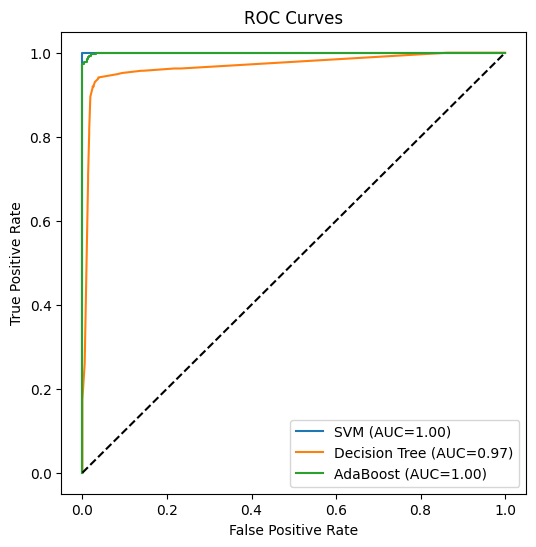

--- SVM ---
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       373
          AI       1.00      1.00      1.00       373

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00      1.00      1.00       746



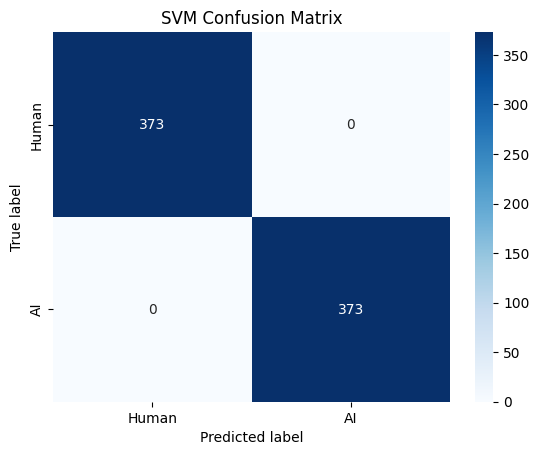

--- Decision Tree ---
              precision    recall  f1-score   support

       Human       0.93      0.97      0.95       373
          AI       0.97      0.93      0.95       373

    accuracy                           0.95       746
   macro avg       0.95      0.95      0.95       746
weighted avg       0.95      0.95      0.95       746



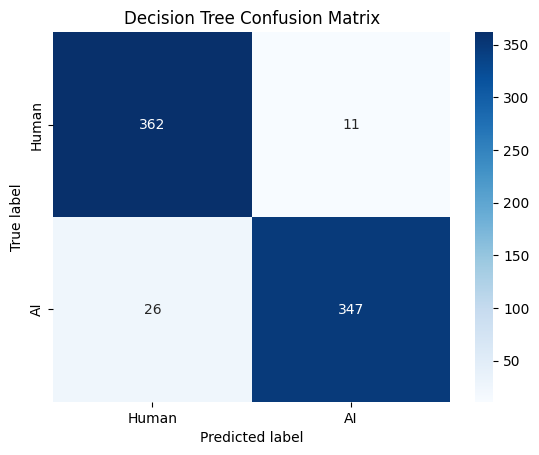

--- AdaBoost ---
              precision    recall  f1-score   support

       Human       0.99      0.99      0.99       373
          AI       0.99      0.99      0.99       373

    accuracy                           0.99       746
   macro avg       0.99      0.99      0.99       746
weighted avg       0.99      0.99      0.99       746



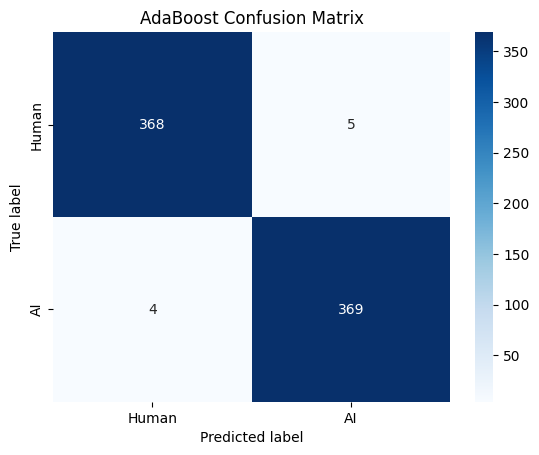

               Accuracy   ROC_AUC
Model                            
SVM            1.000000  1.000000
Decision Tree  0.950402  0.968450
AdaBoost       0.987936  0.999612


In [27]:
# VII. Performance Evaluation & Analysis

# 1. ROC Curves
plt.figure(figsize=(6,6))
for name, pipe in [('SVM', svm_pipeline), ('Decision Tree', dt_pipeline), ('AdaBoost', adb_pipeline)]:
    y_prob = pipe.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# 2. Confusion Matrices & Reports
for name, pipe in [('SVM', svm_pipeline), ('Decision Tree', dt_pipeline), ('AdaBoost', adb_pipeline)]:
    y_pred = pipe.predict(X_val)
    print(f"--- {name} ---")
    print(classification_report(y_val, y_pred, target_names=['Human','AI']))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['Human','AI'],
                yticklabels=['Human','AI'],
                cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 3. Summary Table
results = []
for name, pipe in [('SVM', svm_pipeline), ('Decision Tree', dt_pipeline), ('AdaBoost', adb_pipeline)]:
    y_pred = pipe.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, pipe.predict_proba(X_val)[:,1])
    results.append({'Model': name, 'Accuracy': acc, 'ROC_AUC': auc})

summary_df = pd.DataFrame(results).set_index('Model')
print(summary_df)


In [14]:
import joblib

# 1) Option A: explicit saves
joblib.dump(svm_pipeline, "svm_pipeline.pkl")
joblib.dump(dt_pipeline,  "dt_pipeline.pkl")
joblib.dump(adb_pipeline, "adb_pipeline.pkl")

print("Saved:")
print(" • svm_pipeline.pkl")
print(" • dt_pipeline.pkl")
print(" • adb_pipeline.pkl")

Saved:
 • svm_pipeline.pkl
 • dt_pipeline.pkl
 • adb_pipeline.pkl


In [15]:
# Test with example texts
test_texts = [
    "I love this product! It's amazing and works perfectly.",
    "This is terrible quality. I hate it completely.",
    "The movie was okay, nothing special but watchable.",
    "Outstanding service! Highly recommend to everyone.",
    "Worst experience ever. Never buying again."
]

In [16]:
print(f"Prepared {len(test_texts)} test texts for evaluation")
for i, text in enumerate(test_texts, 1):
    print(f"{i}. {text}")

Prepared 5 test texts for evaluation
1. I love this product! It's amazing and works perfectly.
2. This is terrible quality. I hate it completely.
3. The movie was okay, nothing special but watchable.
4. Outstanding service! Highly recommend to everyone.
5. Worst experience ever. Never buying again.


In [17]:
# Load existing TF-IDF vectorizer
#print("Loading existing TF-IDF vectorizer...")
#tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
#print("TF-IDF vectorizer loaded successfully!")

# Load the saved svm classifier
print("Loading saved SVM classifier...")
loaded_svm_classifier = joblib.load('svm_pipeline.pkl')
print(" SVM classifier loaded successfully!")
svm_available = True
print("Loading saved DT classifier...")
loaded_dt_classifier = joblib.load('dt_pipeline.pkl')
print(" DT classifier loaded successfully!")
dt_available = True
print("Loading saved Adb classifier...")
loaded_adb_classifier = joblib.load('adb_pipeline.pkl')
print(" ADB classifier loaded successfully!")
adb_available = True
# Load the saved LR pipeline for comparison
print("Loading saved Logistic Regression pipeline...")

Loading saved SVM classifier...
 SVM classifier loaded successfully!
Loading saved DT classifier...
 DT classifier loaded successfully!
Loading saved Adb classifier...
 ADB classifier loaded successfully!
Loading saved Logistic Regression pipeline...


In [21]:
#Test SVM Only

if svm_available:
    print("\nTesting SVM...")
    print("=" * 60)

    for i, text in enumerate(test_texts, 1):
        print(f"{i}. Text: {text}")

        # Test on SVM
        svm_prediction = loaded_svm_classifier.predict([text])[0] # Pass text directly
        svm_probability = loaded_svm_classifier.predict_proba([text])[0] # Pass text directly

        svm_sentiment = "AI" if svm_prediction == 1 else "Human"
        svm_confidence = max(svm_probability)

        print(f"   SVM: {svm_sentiment} (Confidence: {svm_confidence:.3f})")
        print(f"   Probabilities: Human: {svm_probability[0]:.3f}, AI: {svm_probability[1]:.3f}")
        print()
else:
    print("Cannot SVM - model not loaded")


Testing SVM...
1. Text: I love this product! It's amazing and works perfectly.
   SVM: Human (Confidence: 0.988)
   Probabilities: Human: 0.988, AI: 0.012

2. Text: This is terrible quality. I hate it completely.
   SVM: Human (Confidence: 0.996)
   Probabilities: Human: 0.996, AI: 0.004

3. Text: The movie was okay, nothing special but watchable.
   SVM: Human (Confidence: 0.998)
   Probabilities: Human: 0.998, AI: 0.002

4. Text: Outstanding service! Highly recommend to everyone.
   SVM: Human (Confidence: 0.893)
   Probabilities: Human: 0.893, AI: 0.107

5. Text: Worst experience ever. Never buying again.
   SVM: Human (Confidence: 0.966)
   Probabilities: Human: 0.966, AI: 0.034



In [24]:
#Test DT Only
if svm_available:
    print("\nTesting Decision Tree...")
    print("=" * 60)

    for i, text in enumerate(test_texts, 1):
        print(f"{i}. Text: {text}")

        # Test on DT
        dt_prediction = loaded_dt_classifier.predict([text])[0] # Pass text directly
        dt_probability = loaded_dt_classifier.predict_proba([text])[0] # Pass text directly

        dt_sentiment = "AI" if svm_prediction == 1 else "Human"
        dt_confidence = max(svm_probability)

        print(f"   DT: {dt_sentiment} (Confidence: {dt_confidence:.3f})")
        print(f"   Probabilities: Human: {dt_probability[0]:.3f}, AI: {dt_probability[1]:.3f}")
        print()
else:
    print("Cannot DT - model not loaded")


Testing Decision Tree...
1. Text: I love this product! It's amazing and works perfectly.
   DT: Human (Confidence: 0.966)
   Probabilities: Human: 0.946, AI: 0.054

2. Text: This is terrible quality. I hate it completely.
   DT: Human (Confidence: 0.966)
   Probabilities: Human: 0.946, AI: 0.054

3. Text: The movie was okay, nothing special but watchable.
   DT: Human (Confidence: 0.966)
   Probabilities: Human: 0.946, AI: 0.054

4. Text: Outstanding service! Highly recommend to everyone.
   DT: Human (Confidence: 0.966)
   Probabilities: Human: 0.946, AI: 0.054

5. Text: Worst experience ever. Never buying again.
   DT: Human (Confidence: 0.966)
   Probabilities: Human: 0.946, AI: 0.054



In [28]:
#Test Ada Boost Only
if adb_available:
    print("\nTesting Ada Boost...")
    print("=" * 60)

    for i, text in enumerate(test_texts, 1):
        print(f"{i}. Text: {text}")

        # Test on ADB
        adb_prediction = loaded_adb_classifier.predict([text])[0] # Pass text directly
        adb_probability = loaded_adb_classifier.predict_proba([text])[0] # Pass text directly

        adb_sentiment = "AI" if adb_prediction == 1 else "Human"
        adb_confidence = max(adb_probability)

        print(f"   DT: {adb_sentiment} (Confidence: {adb_confidence:.3f})")
        print(f"   Probabilities: Human: {adb_probability[0]:.3f}, AI: {adb_probability[1]:.3f}")
        print()
else:
    print("Cannot AdaBoost - model not loaded")


Testing Ada Boost...
1. Text: I love this product! It's amazing and works perfectly.
   DT: Human (Confidence: 0.529)
   Probabilities: Human: 0.529, AI: 0.471

2. Text: This is terrible quality. I hate it completely.
   DT: Human (Confidence: 0.529)
   Probabilities: Human: 0.529, AI: 0.471

3. Text: The movie was okay, nothing special but watchable.
   DT: Human (Confidence: 0.529)
   Probabilities: Human: 0.529, AI: 0.471

4. Text: Outstanding service! Highly recommend to everyone.
   DT: Human (Confidence: 0.529)
   Probabilities: Human: 0.529, AI: 0.471

5. Text: Worst experience ever. Never buying again.
   DT: Human (Confidence: 0.529)
   Probabilities: Human: 0.529, AI: 0.471



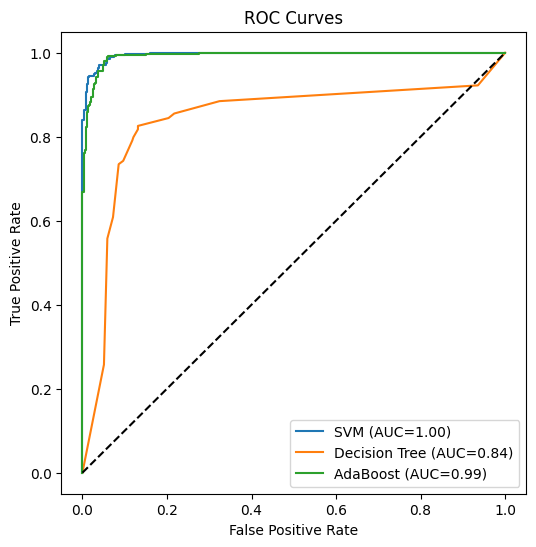

--- SVM ---
              precision    recall  f1-score   support

       Human       0.97      0.95      0.96       373
          AI       0.96      0.97      0.96       373

    accuracy                           0.96       746
   macro avg       0.96      0.96      0.96       746
weighted avg       0.96      0.96      0.96       746



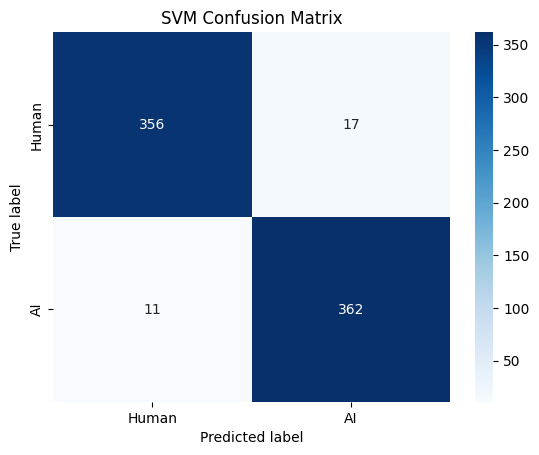

--- Decision Tree ---
              precision    recall  f1-score   support

       Human       0.83      0.87      0.85       373
          AI       0.86      0.82      0.84       373

    accuracy                           0.84       746
   macro avg       0.84      0.84      0.84       746
weighted avg       0.84      0.84      0.84       746



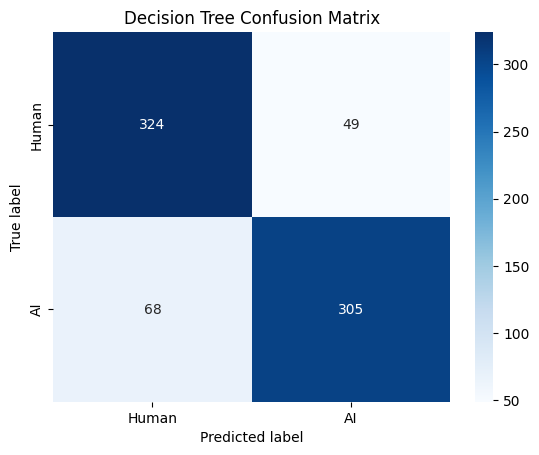

--- AdaBoost ---
              precision    recall  f1-score   support

       Human       0.97      0.95      0.96       373
          AI       0.95      0.97      0.96       373

    accuracy                           0.96       746
   macro avg       0.96      0.96      0.96       746
weighted avg       0.96      0.96      0.96       746



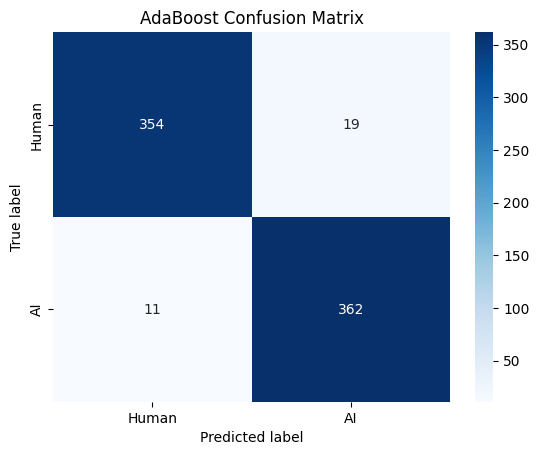

               Accuracy   ROC_AUC
Model                            
SVM            0.962466  0.995961
Decision Tree  0.843164  0.841061
AdaBoost       0.959786  0.993208


In [13]:
# VII. Performance Evaluation & Analysis

# 1. ROC Curves
plt.figure(figsize=(6,6))
for name, gs in [('SVM', svm_gs), ('Decision Tree', dt_gs), ('AdaBoost', adb_gs)]:
    y_prob = gs.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# 2. Confusion Matrices & Reports
for name, gs in [('SVM', svm_gs), ('Decision Tree', dt_gs), ('AdaBoost', adb_gs)]:
    y_pred = gs.predict(X_val)
    print(f"--- {name} ---")
    print(classification_report(y_val, y_pred, target_names=['Human','AI']))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['Human','AI'],
                yticklabels=['Human','AI'],
                cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 3. Summary Table
results = []
for name, gs in [('SVM', svm_gs), ('Decision Tree', dt_gs), ('AdaBoost', adb_gs)]:
    y_pred = gs.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, gs.predict_proba(X_val)[:,1])
    results.append({'Model': name, 'Accuracy': acc, 'ROC_AUC': auc})

summary_df = pd.DataFrame(results).set_index('Model')
print(summary_df)
